In [1]:
import pandas as pd
import numpy as np
import os

pd.set_option('max_columns', None)
pd.set_option('max_rows', 2500)

# loading a couple of libraries for binning and plotting
from scipy.stats import binned_statistic_2d
from mplsoccer.pitch import Pitch, VerticalPitch

# for visualising the matrices
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import xGils.deltaxT as deltaxT

# **Team xT**

Starting very simply, we want to sum up the binned xT for each team per season. This will give us a vector that characterises the attacking threat of a team.

# **Delta xT**

Attacking threat can be measured **directly**: looking at the passes, crosses, dribbles, and shots of a team.

Defending always difficult to measure with **on-the-ball** events data because so much of the art of defending happens **off-the-ball**. Maldini quote: "If I have to make a tackle, I've already made a mistake."

So we use *delta xT* to indirectly probe at the ways in which opposing teams re-direct their threat at a given team, compared to how they play against all other teams, on average. This is *delta xT*.

## **Loading Opta Bayesian xT Data**

In [2]:
%%time

df_opta_xT = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT/Bayesian_Opta_xT.csv')

# converting the timestamp string to a datetime
df_opta_xT['timeStamp'] = pd.to_datetime(df_opta_xT.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df_opta_xT['kickOffDateTime'] = pd.to_datetime(df_opta_xT.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

print (f'{len(df_opta_xT)} rows loaded.\n')

df_opta_xT.head()

3126182 rows loaded.

CPU times: user 13.5 s, sys: 1.57 s, total: 15.1 s
Wall time: 15.4 s


,competition,season,seasonIndex,gameMonthIndex,matchId,playerId,playerName,position,detailedPosition,playerTeamId,minsPlayed,subIn,subOut,replacedReplacingPlayerId,booking,eventType,eventSubType,eventTypeId,x1,y1,x2,y2,gameTime,timeStamp,periodId,homeTeamName,homeTeamId,awayTeamName,awayTeamId,kickOffDateTime,minute,second,x1_m,y1_m,x2_m,y2_m,xT
0,English Premier League,2017/18,1,24212,918893,59966,Alexandre Lacazette,Forward,Striker,3,95,NaN,NaN,NaN,NaN,attack,Pass,1,50.0,50.7,28.8,30.1,0:1,2017-08-11 19:46:04.968,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,1,52.500,34.476,30.240,20.468,-0.003278
1,English Premier League,2017/18,1,24212,918893,156074,Rob Holding,Defender,FullBack,3,67,NaN,1.0,NaN,NaN,attack,Pass,1,29.7,26.7,52.3,21.5,0:2,2017-08-11 19:46:05.554,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,2,31.185,18.156,54.915,14.620,0.003008
2,English Premier League,2017/18,1,24212,918893,37605,Mesut Özil,Forward,AttackingMidfielder,3,95,NaN,NaN,NaN,NaN,attack,Pass,1,52.8,21.3,44.3,20.7,0:5,2017-08-11 19:46:08.554,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,5,55.440,14.484,46.515,14.076,-0.001186
3,English Premier League,2017/18,1,24212,918893,153256,Mohamed Elneny,Midfielder,CentralMidfielder,3,66,NaN,1.0,NaN,NaN,attack,Pass,1,44.0,19.6,50.3,4.2,0:7,2017-08-11 19:46:10.554,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,7,46.200,13.328,52.815,2.856,-0.000542
4,English Premier League,2017/18,1,24212,918893,98745,Héctor Bellerín,Midfielder,RightMidfielder,3,95,NaN,NaN,NaN,NaN,attack,Pass,1,51.0,4.2,70.5,5.0,0:9,2017-08-11 19:46:13.519,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,9,53.550,2.856,74.025,3.400,0.005850


In [3]:
# pass events (inc. crosses)
opta_successful_pass_events = ['2nd Assist','Assist','Chance Created','Cross','Pass']
opta_failed_pass_events = ['Failed Pass','Offside Pass']

# dribble events
opta_successful_dribble_events = ['Dribble']
opta_failed_dribble_events = ['Failed Dribble']

# shot events
opta_successful_shot_events = ['Goal']
opta_failed_shot_events = ['Hit Woodwork','Miss','Missed Penalty','Penalty Saved','Shot Blocked','Shot Saved']

opta_events_successful = opta_successful_pass_events + opta_successful_dribble_events + opta_successful_shot_events
opta_events_relevant = opta_successful_pass_events + opta_failed_pass_events + opta_successful_dribble_events + opta_failed_dribble_events + opta_successful_shot_events + opta_failed_shot_events

opta_events_relevant

['2nd Assist',
 'Assist',
 'Chance Created',
 'Cross',
 'Pass',
 'Failed Pass',
 'Offside Pass',
 'Dribble',
 'Failed Dribble',
 'Goal',
 'Hit Woodwork',
 'Miss',
 'Missed Penalty',
 'Penalty Saved',
 'Shot Blocked',
 'Shot Saved']

---

## **Team xT**

In [4]:
# things we want data for
competition = 'English Premier League'
seasons = ['2017/18','2018/19','2019/20','2020/21']

# just interested in the EPL for this analysis, for the seasons specified above
df_xT = df_opta_xT.loc[(df_opta_xT['competition'] == competition) & (df_opta_xT['season'].isin(seasons))].copy().reset_index(drop=True)

# producing a dataframe for team ref
df_epl_teams = deltaxT.produce_df_teams_ref(df_xT)
df_epl_teams

,teamName,teamId
0,Manchester United,1
1,Leeds United,2
2,Arsenal,3
3,Newcastle United,4
4,Tottenham Hotspur,6
5,Aston Villa,7
6,Chelsea,8
7,Everton,11
8,Leicester City,13
9,Liverpool,14


### **Exploratory Code**

#### Looking at most common coords

In [5]:
df_opta_xT.groupby(['x1_m','y1_m'])\
        .agg({'playerId':'count'})\
        .reset_index()\
        .rename(columns={'playerId':'freq'})\
        .sort_values('freq', ascending=False)\
        .head(10)

,x1_m,y1_m,freq
748790,104.475,67.660,7801
0,0.000,0.000,7680
748731,104.475,0.340,7615
395097,52.500,34.000,839
394720,52.395,34.000,512
21163,5.250,25.160,510
21390,5.250,42.840,501
395476,52.605,34.000,496
395475,52.605,33.932,468
394719,52.395,33.932,468


#### Aggregating xT Per Team Per Season

In [6]:
df_xT.groupby(['season','playerTeamId']).agg({'x1_m':'count'}).reset_index()\
    .rename(columns={'x1_m':'numEvents'})\
    .sort_values(['playerTeamId','season'], ascending=[True,True])\
    .head()

,season,playerTeamId,numEvents
0,2017/18,1,36001
20,2018/19,1,34841
40,2019/20,1,35473
60,2020/21,1,35528
61,2020/21,2,34558


### **Initial Look at Team xT**

**Purely grouping and summing per EPL team per season**

> TODO: Could definitely put 10 teams in a bumpy chart

In [7]:
df_team_xT_total = df_xT.groupby(['competition','season','playerTeamId'])\
                    .agg({'xT':np.sum})\
                    .reset_index()\
                    .merge(df_epl_teams, left_on=['playerTeamId'], right_on=['teamId'])\
                    .drop(columns=['playerTeamId'])\
                    [['season','teamName','teamId','xT']]

df_team_xT_total

,season,teamName,teamId,xT
0,2017/18,Manchester United,1,35.969278
1,2018/19,Manchester United,1,37.888261
2,2019/20,Manchester United,1,29.991356
3,2020/21,Manchester United,1,34.404555
4,2017/18,Arsenal,3,42.259737
5,2018/19,Arsenal,3,37.127155
6,2019/20,Arsenal,3,26.558598
7,2020/21,Arsenal,3,28.341500
8,2017/18,Newcastle United,4,28.894425
9,2018/19,Newcastle United,4,28.869258


### **Function to sum xT into bins per team**

> What should this function look like?

> Probably should be nice and clean, producing a team's xT vector for that seasondf_xT.playerTeamId.drop_duplicates().values

### **Plotting xT for a Particular Team for a Particular Season**

#### Manchester United 2020/21

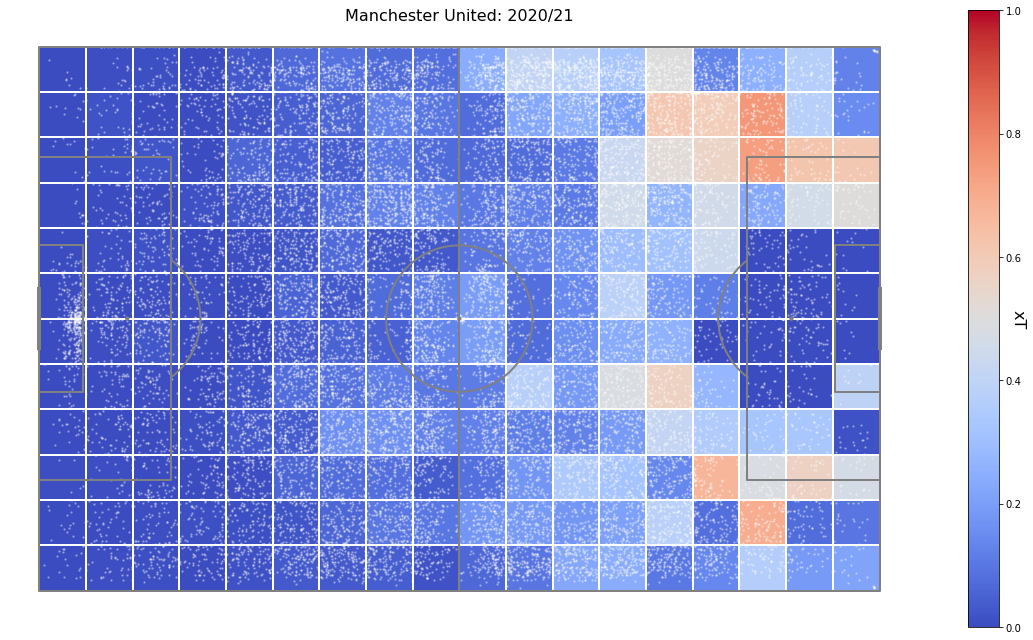

In [8]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 1) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/MUFC_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

#### Chelsea 2020/21

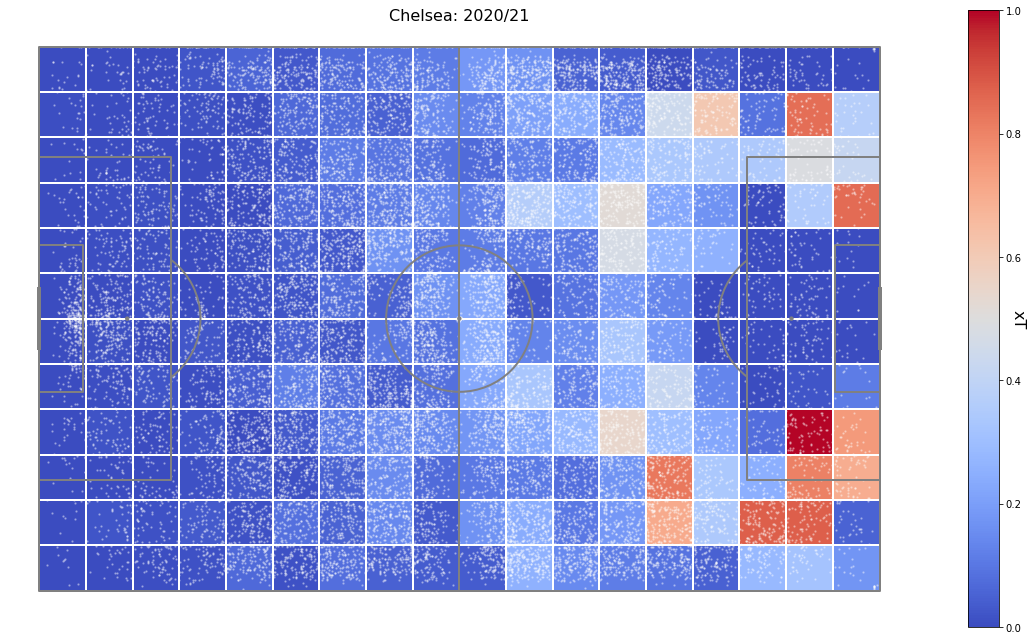

In [9]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 8) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/Chelsea_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

#### Liverpool 2020/21

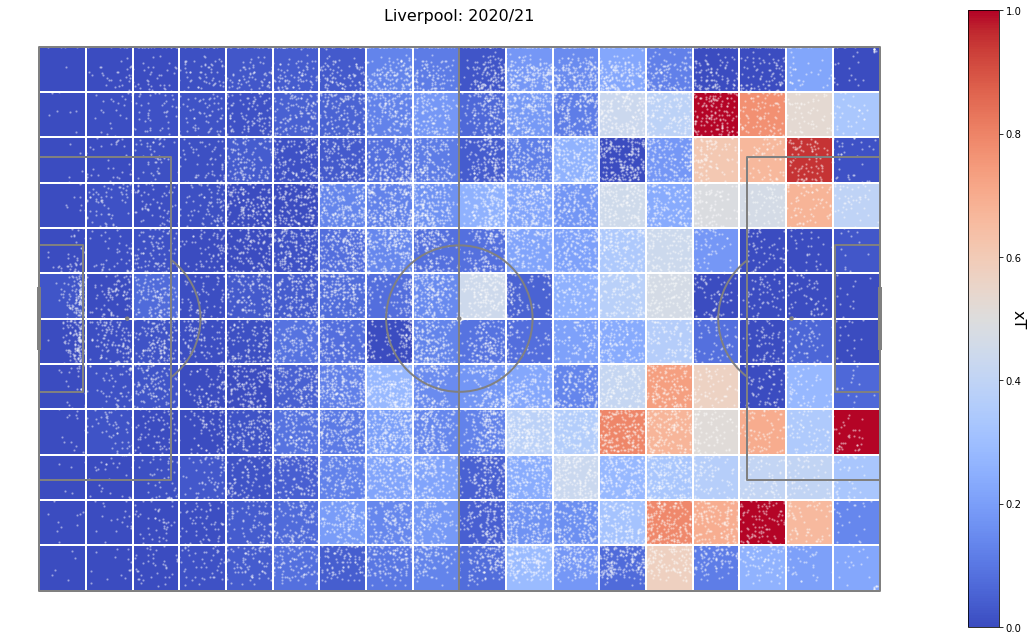

In [10]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 14) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/Liverpool_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

#### Arsenal 2020/21

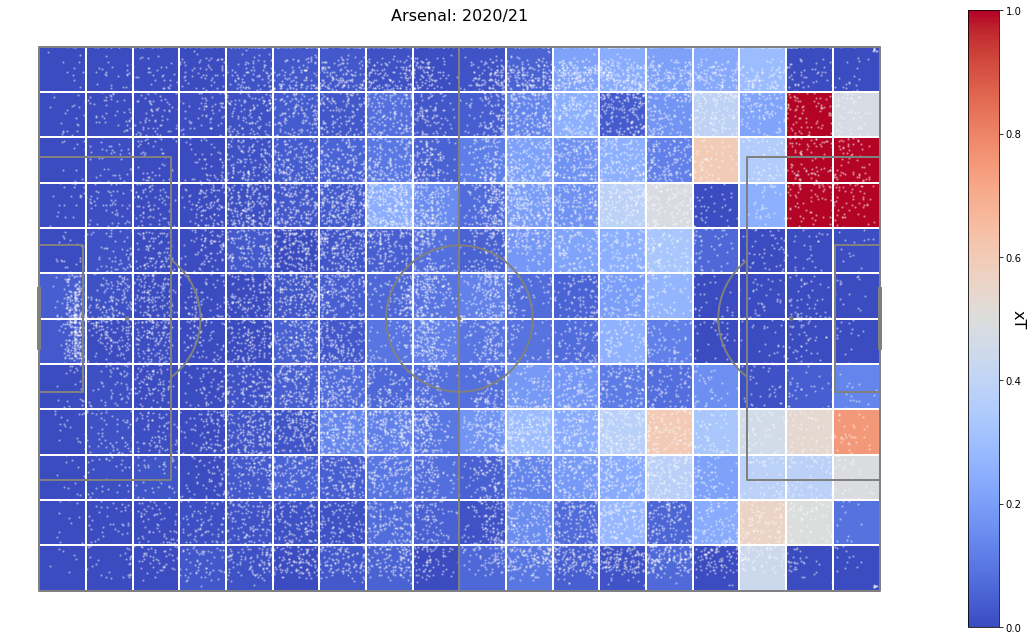

In [11]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 3) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/Arsenal_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

#### Manchester City 2020/21

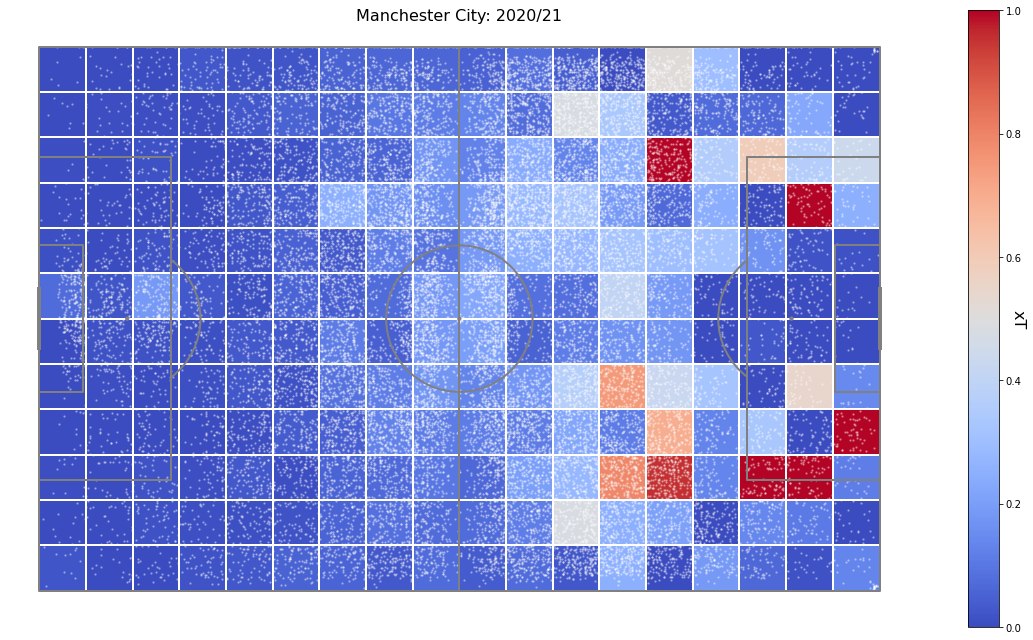

In [12]:
df_plot = df_xT.loc[(df_xT['playerTeamId'] == 43) & (df_xT['season'] == '2020/21')].reset_index(drop=True).copy()
filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/City_2020_21.png'
deltaxT.plot_xT_pitch(df_plot, opta_events_relevant, filepath, transparent=False, teamOrPlayer='team', bins=(18,12), fontsize=16, cmap=cm.coolwarm, vmax_override=1.0)

### **Plotting xT for a Range of Seasons for a Range of Teams**

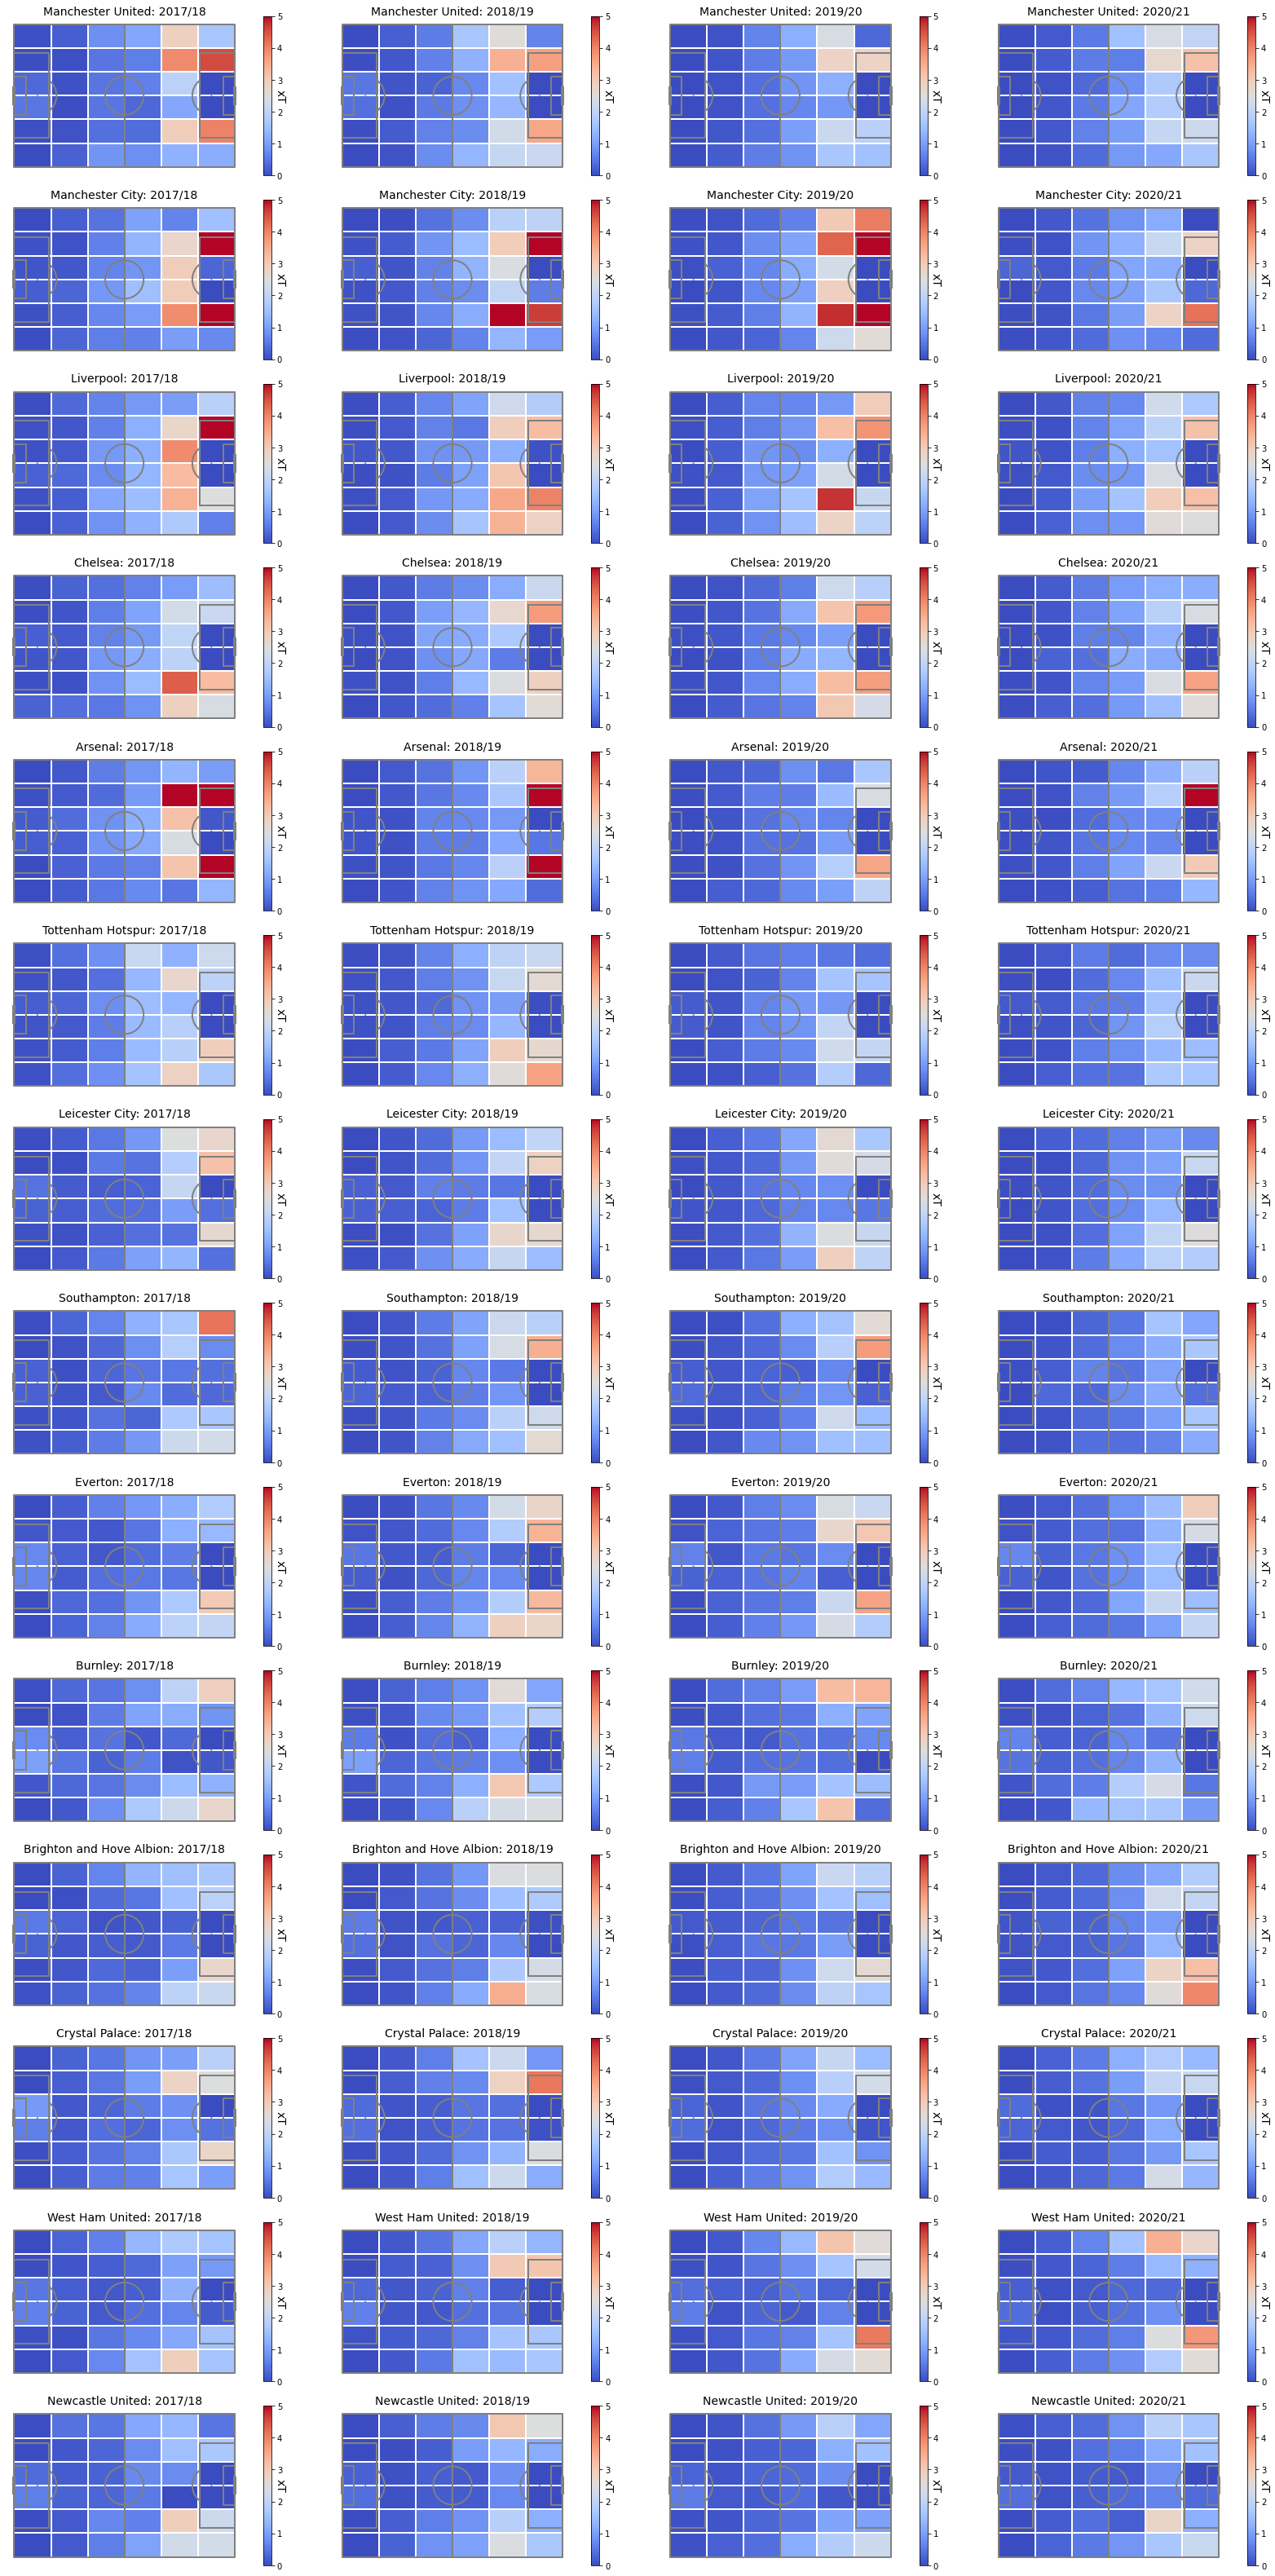

In [13]:
lst_teams = [1,43,14,8,3,6,13,20,11,90,36,31,21,4]
seasons = ['2017/18','2018/19','2019/20','2020/21']
cols = ['Reds','Blues','Reds','Blues','Reds','Blues']

filepath = '/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/Team xT/MajorClubs.png'

deltaxT.plot_xT_multi_pitch(df_xT, opta_events_relevant, lst_teams, seasons, [cm.coolwarm]*len(lst_teams), filepath, transparent=False, teamOrPlayer='team', eventCol='eventSubType', bins=(6,6), figsize=(24,44), fontsize=14, vmax_override=5, scatter=0)

---

## **Delta xT**

> This is the key bit

> Want to get a nice function to calculate the Delta xT statistics, and then a complementary plotting function (almost exactly like the above).

> Will probably have a few mini helper functions for the matches.

In [140]:
def produce_df_matches_ref(df):
    """
    Produces data frame of match reference data from events dataframe for the season of interest.
    """
    
    return df[['matchId','homeTeamId','awayTeamId']].drop_duplicates().reset_index(drop=True).copy()


def delta_xT_grid(df, teamId, events, eventCol='eventSubType', bins=(18,12), exclCorners = 1):
    
    """
    Input should entire events dataframe for the competition / season of interest.
    
    Must specify team of interest to calculate delta xT statistics for.

    To make life easier when plotting / aggregating statistics between Opta and Wyscout, we'll use standardised Uefa coordinate system throughout.

    Key: the required columns in the event dataframe are [...]
    """
    
    # instantiate a Uefa pitch object (pitch dimensions: [[0,105],[0,68]])
    pitch = Pitch(pitch_type='uefa', pitch_color='white', line_zorder=2, line_color='gray')
    
    # can be useful to exclude corners from this analysis
    ## 1) statistically: corners don't really characterise the way a team threatens the opponent
    ## 2) visually: as corners are such focussed events w.r.t. location, so they dominate and detract from the team's grid if they're included
    if exclCorners == 1:
        df = df.loc[~((df['x1_m'] >= 104.4) & (df['y1_m'] >= 67.5))].reset_index(drop=True)
        df = df.loc[~((df['x1_m'] >= 104.4) & (df['y1_m'] <= 0.5))].reset_index(drop=True)
    
    # starting by generating dataframe of matches for ALL teams in the competition per season
    df_matches = produce_df_matches_ref(df)
    
    # getting list of OTHER TEAMS (i.e. the 19 other teamId's that aren't the team of interest)
    # we just ask for the unique list of awayTeamId's when the teamId is the home team.
    lst_otherTeamId = df_matches.loc[df_matches['homeTeamId'] == teamId, 'awayTeamId'].drop_duplicates().values
    
    # creating a dictionary of matches (want something that's easily queryable to get matches involving
    # the team of interest and "other" matches)
    # dict: {matchId: [home, away]}
    dic_matches = {i:[j,k] for i,j,k in zip(df_matches.matchId,df_matches.homeTeamId,df_matches.awayTeamId)}
    
    # keeping track of each of the delta matrices
    lst_matrix_Delta = []
    
    # looping through opponents
    for otherTeamId in lst_otherTeamId:
        
        # we'll be storing the xT grids for matches VS our team of interest and matches against OTHER teams in lists
        lst_matrix_Vs = []
        lst_matrix_Other = []
        
        # getting list and number of matchId's VS our team of interest
        lst_matchId_Vs = [i for i in dic_matches.keys() if otherTeamId in dic_matches[i] and teamId in dic_matches[i]]
        numVs = len(lst_matchId_Vs)
        
        # getting list and number of matchId's against OTHER teams
        lst_matchId_Other = [i for i in dic_matches.keys() if otherTeamId in dic_matches[i] and teamId not in dic_matches[i]]
        numOther = len(lst_matchId_Other)
        
        # 1) matches VS
        for matchId in lst_matchId_Vs:
            # producing dataframe just for that match, purely containing actions by the other team
            df_xT_match = df.loc[(df['matchId'] == matchId) & (df['playerTeamId'] == otherTeamId)].copy()
            # appending binned sums of xT (a matrix) to a list of matrices 
            lst_matrix_Vs.append(pitch.bin_statistic(df_xT_match.x1_m, df_xT_match.y1_m, df_xT_match.xT, statistic='sum', bins=bins)['statistic'])
        
        # 2) matches against OTHER
        for matchId in lst_matchId_Other:
            # producing dataframe just for that match, purely containing actions by the other team
            df_xT_match = df.loc[(df['matchId'] == matchId) & (df['playerTeamId'] == otherTeamId)].copy()
            lst_matrix_Other.append(pitch.bin_statistic(df_xT_match.x1_m, df_xT_match.y1_m, df_xT_match.xT, statistic='sum', bins=bins)['statistic'])
            
        # calculating averages: numpy performing element wise averages per bin
        mean_matrix_Vs = np.mean(lst_matrix_Vs, axis=0)
        mean_matrix_Other = np.mean(lst_matrix_Other, axis=0)
        
        # calculating delta xT
        ## subtracting the xT average against OTHER teams from VS
        ## this means when there's excess xT (a positive value) left, then other teams are specifically targeting that area
        ## and negative xT is when other teams specifically don't target those regions against the team of interest, but they normally would against other opponents
        matrix_Delta = mean_matrix_Vs - mean_matrix_Other
        
        lst_matrix_Delta.append(matrix_Delta)
        
    # and now calculating the average delta
    mean_matrix_Delta = np.mean(lst_matrix_Delta, axis=0)
    var_matrix_Delta = np.var(lst_matrix_Delta, axis=0)
    
    # and calculating the numDeltas as this is our sample size, if we want to calculate the standard error in the mean
    numDeltas = len(lst_matrix_Delta)
    
    # hacky bit that'll save a lot of headaches when it comes to plotting this
    ## 1) calculate arbitrary bin statistic with the bin definition that you're using
    bs = pitch.bin_statistic(df_xT_match.x1_m, df_xT_match.y1_m, df_xT_match.xT, statistic='sum', bins=bins)
    
    ## 2) override the statistic part of the bin statistic data object with the mean_matrix_Delta
    bs['statistic'] = mean_matrix_Delta
    
    return (mean_matrix_Delta, bs, numDeltas)

In [170]:
df_test = df_xT.loc[df_xT['season'] == '2020/21'].reset_index(drop=True).copy()

### Testing Delta xT with Man U: teamId = 1, season: 2020/21

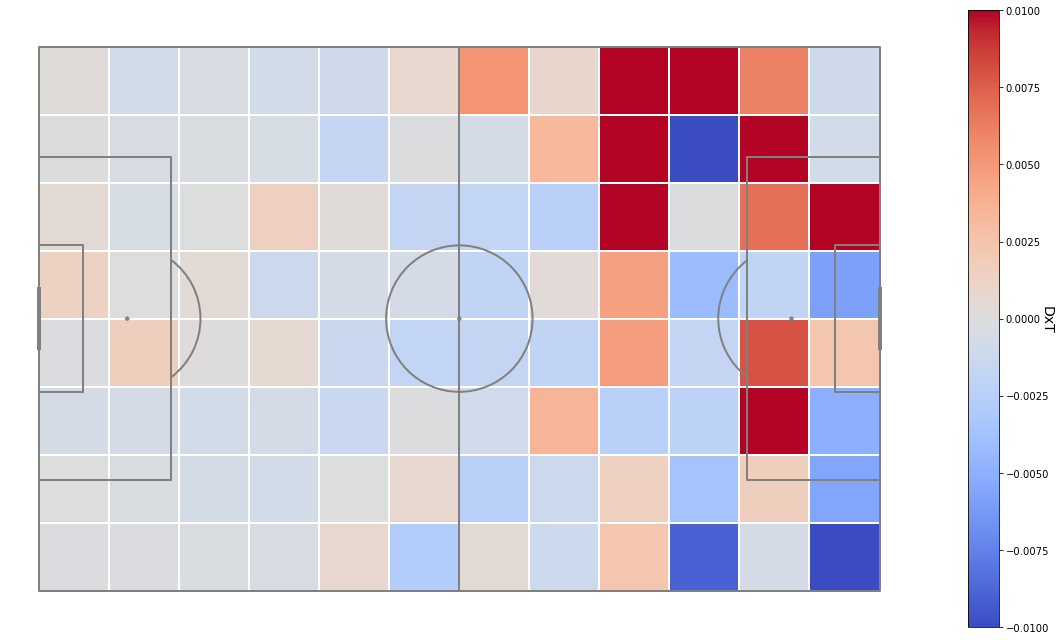

In [171]:
test_payload = delta_xT_grid(df_test, 20, opta_events_relevant, eventCol='eventSubType', bins=(12,8), exclCorners = 1)
test_stats = test_payload[0]
test_plot = test_payload[1]
numDeltas  = test_payload[2]

## PLOTTING BIT
pitch = Pitch(pitch_type='uefa', pitch_color='white', line_zorder=2, line_color='gray')
fig, ax = pitch.draw(figsize=(16,9))

vmin, vmax = (test_stats).min(), (test_stats).max()
hm = pitch.heatmap(test_plot, ax=ax, cmap=cm.coolwarm, edgecolors='white', vmin=-0.01, vmax=0.01)
cbar = fig.colorbar(hm, ax=ax)
cbar.set_label('DxT', rotation=270, fontsize=14)

In [145]:
numDeltas

19

In [148]:
deltaxT.produce_df_teams_ref(df_xT)

,teamName,teamId
0,Manchester United,1
1,Leeds United,2
2,Arsenal,3
3,Newcastle United,4
4,Tottenham Hotspur,6
5,Aston Villa,7
6,Chelsea,8
7,Everton,11
8,Leicester City,13
9,Liverpool,14


In [33]:
a = np.array([10, 20, 30, 2]).reshape(2,2)

b = np.array([30, 20, 20, 2]).reshape(2,2)

c = np.array([50, 21, 40, 3]).reshape(2,2)

In [34]:
a

array([[10, 20],
       [30,  2]])

In [35]:
b

array([[30, 20],
       [20,  2]])

In [36]:
c

array([[50, 21],
       [40,  3]])

In [37]:
np.mean([a,b,c], axis=0)

array([[30.        , 20.33333333],
       [30.        ,  2.33333333]])

In [41]:
np.std([a,b,c], axis=0)

array([[16.32993162,  0.47140452],
       [ 8.16496581,  0.47140452]])

## Will come up with a two sample T-test for each bin and see whether it's significantly non-zero.

Use simple Welsh two-sample T-test to start with.

And we're dealing with means.

Plot the $p$-values on greyscale.